<a href="https://colab.research.google.com/github/6yuvaldavid/Anomaly-Detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds

%matplotlib inline
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
img_height = 28
img_width = 28
batch_size = 30

### Loading the data

In [3]:
import pathlib
data_dir = 'data'
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*.png')))
print(image_count)

100


In [5]:
roses = list(data_dir.glob('*.png'))
PIL.Image.open(str(roses[1]))

### preprocessing the data, i.e scale it by 255 and load the minst data with the 1,2 digits also preprocess it to match our data

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = None,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 1 classes.


In [7]:
x_test = np.concatenate([x for x in val_ds], axis=0)
x_test = x_test.astype('float32') / 255.

In [8]:
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_val, Y_val) = mnist.load_data()

import numpy as np

train_mask = np.isin(Y_train, [1, 2])
test_mask = np.isin(Y_val, [1, 2])

print(len(X_train))

X_train = X_train[train_mask]
X_val = X_val[test_mask]

X_train = X_train / 255.


# Set reshaped array to X 
X_train = X_train.reshape(len(X_train), 28, 28, 1)

# Convert images and store them
X_train = tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(X_train)
)

X_val = X_val / 255.

# Set reshaped array to X 
X_val = X_val.reshape((len(X_val), 28, 28, 1))

# Convert images and store them
X_val = tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(X_val)
)
print(len(X_val))

60000
2167


### create and train the model

In [9]:
latent_dim = 128 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(2352, activation='sigmoid'),
      layers.Reshape((28, 28, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [10]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [11]:
autoencoder.fit(X_train, X_train,validation_data=(X_val, X_val),
                epochs=20)

Epoch 1/20
397/397 [==============================] - 5s 11ms/step - loss: 0.0307 - val_loss: 0.0134
Epoch 2/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 3/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 4/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 5/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/20
397/397 [==============================] - 4s 10ms/step - loss: 0.0023 - val_lo

### Test our model for 10 example from the unused test test

In [12]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

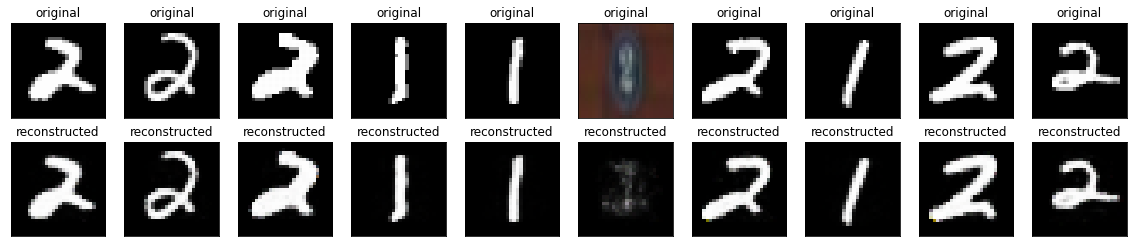

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i+50])
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i+50])
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Find the reconstruction error rate

In [14]:
encoded_data = autoencoder.encoder(x_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [15]:
reconstructions = autoencoder.predict(x_test)
train_loss = tf.keras.losses.mae(reconstructions, x_test)

In [16]:
loss = tf.reduce_sum(train_loss, 2).numpy()

In [17]:
loss = loss.sum(axis=1)

In [18]:
indices = (-loss).argsort()[0:20]

In [19]:
indices

array([60, 76, 46, 29,  3, 10, 24,  0, 55,  6, 27, 32, 78, 31, 72, 26, 52,
       18, 93, 86])

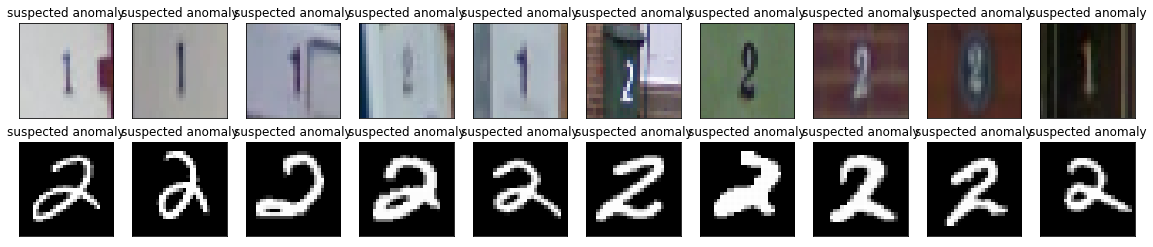

In [20]:
n = 100
t=1
plt.figure(figsize=(20, 4))
for i in indices:
  # display reconstruction
    
  ax = plt.subplot(2, 10, t)

  plt.imshow(x_test[i])
  plt.title("suspected anomaly")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  t+=1
plt.show()

In [21]:
loss[indices]

array([453.80035 , 427.02252 , 423.00864 , 401.02402 , 387.43637 ,
       316.42087 , 275.8804  , 183.92429 , 149.27396 ,  79.99257 ,
        20.977215,  19.528938,  18.152393,  18.104542,  17.081572,
        16.922825,  16.380024,  16.376108,  15.821573,  15.623974],
      dtype=float32)

### so as we can see our minst construction error is at max 20 while the anomalies are at min 70 so we say that if the error is above 45 we will label it as anomaly

In [22]:
errors_indices = loss > 45

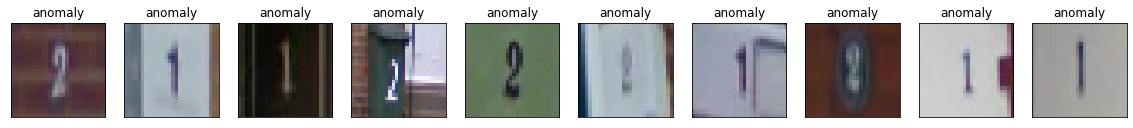

In [23]:
n = 100
t=1
plt.figure(figsize=(20, 4))
for image in x_test[errors_indices]:
  # display reconstruction
    
  ax = plt.subplot(2, 10, t)

  plt.imshow(image)
  plt.title("anomaly")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  t+=1
plt.show()

### as we can see we deteced all the anomlies time to test it with new unseen data to check if our threshold (of 45) holds